# Lecture 9

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import numpy.random as random

## Q 9.1
### Question

Define three L-systems and draw the corresponding fractals. Requirements:

1. Provide definitions of the L-systems (axiom, rules, angle, etc.)
2. Provide screenshots of the fractals at different iterations

### Solution

Please first forgive me for using python instead of matlab here. I don't want to start an argument here, but matlab just suck so bad that it would take me 10 times more to write matlab code than python. After three weeks of matlab coding, I can confirm that it's not due to unfamiliarity of matlab, but the language itself. I'm not planning to use matlab in the future, and I hope you can understand and support my choice.

You can see some matlab code attached to this homework, namely `Q9_1_1.m` and `Q9_2_2.m`, they both work, but reusing them or even reading them brings me headache, and I believe who actually want to code any real stuff in 2023 should not use matlab.

#### Task 0

We can treat the L-system as a finite state machine, we store the definitions of each L-system as the following:

```python
axiom = "F-F-F" # the initial state
iteration_rules = {
    "F": "F-G+F+G-F", # the rules, which could be generated using iteration & finite state machine
    "G": "GG"
}
angle_base = np.pi / 2 # the angle of each turn
```

As for the `[` and `]`, we treat them as a stack of history, each time `[` begins we push the current state and angle to the stack, and each time `]` ends we pop the state and angle from the stack.

In [2]:
def apply_iteration_rules(axiom, rules, n):
    if n == 0:
        return axiom
    else:
        new_axiom = ""
        for c in axiom:
            if c in rules:
                new_axiom += rules[c]
            else:
                new_axiom += c
        return apply_iteration_rules(new_axiom, rules, n - 1)

In [3]:
def draw(axiom, iteration_rules, process, angle_base, n, ax=None):
    lines_to_draw = []  # (x,y) pairs of complex numbers
    rule = apply_iteration_rules(axiom, iteration_rules, n)
    cur = 0
    angle = angle_base
    angle_stack = []
    position_stack = []
    for c in rule:
        if c == "[":
            angle_stack.append(angle)
            position_stack.append(cur)
        elif c == "]":
            angle = angle_stack.pop()
            cur = position_stack.pop()
        else:
            cur, angle, lines_to_draw = process(c, cur, angle, lines_to_draw)
    if ax is None:
        plt.figure()
        ax = plt.gca()

    ax.axis("off")
    ax.set_aspect("equal")
    for line in lines_to_draw:
        ax.plot([line[0].real, line[1].real], [line[0].imag, line[1].imag], color="black")


#### Task 1 Sierpinski triangle

Note: definition of these three L-systems are from [Wikipedia](https://en.wikipedia.org/wiki/L-system)

In [4]:
# Sierpinski triangle
axiom = "F-F-F"
iteration_rules = {
    "F": "F-G+F+G-F",
    "G": "GG"
}
angle_base = np.pi / 2


def process(c, cur, angle, lines_to_draw):
    if c == "F":
        next = cur + np.exp(1j * angle)
        lines_to_draw.append((cur, next))
        cur = next
    elif c == "G":
        next = cur + np.exp(1j * angle)
        cur = next
    elif c == "+":
        angle += np.pi / 3 * 2
    elif c == "-":
        angle -= np.pi / 3 * 2
    return cur, angle, lines_to_draw

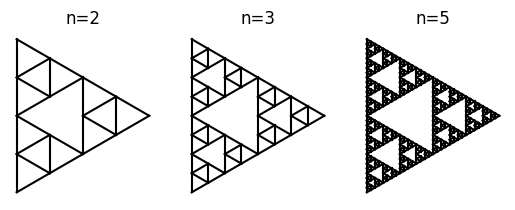

In [5]:
n_list = [2, 3, 5]
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title("n={}".format(n_list[i]))
    ax.axis("off")
    ax.set_aspect("equal")
    draw(axiom, iteration_rules, process, angle_base, n_list[i], ax=ax)

#### Task 2 Koch curve

In [6]:
# Koch curve
axiom = "F"
iteration_rules = {
    "F": "F+F-F-F+F"
}
angle_base = 0


def process(c, cur, angle, lines_to_draw):
    if c == "F":
        next = cur + np.exp(1j * angle)
        lines_to_draw.append((cur, next))
        cur = next
    elif c == "+":
        angle += np.pi / 2
    elif c == "-":
        angle -= np.pi / 2
    return cur, angle, lines_to_draw

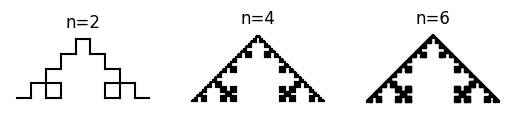

In [7]:
n_list = [2, 4, 6]
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title("n={}".format(n_list[i]))
    ax.axis("off")
    ax.set_aspect("equal")
    draw(axiom, iteration_rules, process, angle_base, n_list[i], ax=ax)

#### Task 3 Fractal plant

In [8]:
# fractal plant
axiom = "X"
iteration_rules = {
    "X": "F+[[X]-X]-F[-FX]+X",
    "F": "FF"
}
angle_base = np.pi / 4


def process(c, cur, angle, lines_to_draw):
    if c == "F":
        next = cur + np.exp(1j * angle)
        lines_to_draw.append((cur, next))
        cur = next
    elif c == "+":
        angle += np.deg2rad(25)
    elif c == "-":
        angle -= np.deg2rad(25)
    return cur, angle, lines_to_draw

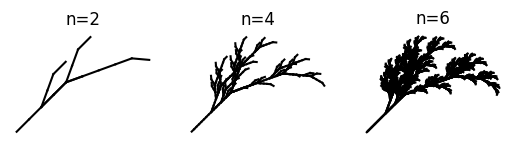

In [9]:
n_list = [2, 4, 6]
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.set_title("n={}".format(n_list[i]))
    ax.axis("off")
    ax.set_aspect("equal")
    draw(axiom, iteration_rules, process, angle_base, n_list[i], ax=ax)

## Q 9.2
### Question

Write a program to plot Julia sets, for each $(p,q)$ pair taking the following values, watch what happens to the Julia set. Zooming in these sets, do you see any self-similarity?

$(0,1), (-1,0), (0.11,0.66), (-010281,0.95723), (-1.25,-0.01)$

### Solution

In [40]:
def julia_set(p, q, M=2, N=50, resolution=500, K=16):
    assert (M >= np.sqrt(p ** 2 + q ** 2))

    mu = p + 1j * q
    x = np.linspace(-M, M, resolution, dtype=np.longfloat)
    y = np.linspace(-M, M, resolution, dtype=np.longfloat)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y
    
    J = np.zeros(shape=(resolution, resolution), dtype=np.int8)
    MASK = np.ones(shape=(resolution, resolution), dtype=np.bool_)

    for i in range(N):
        Z = Z ** 2 + mu
        J += (np.abs(Z) < 4) * MASK
        MASK = (np.abs(Z) < 4) * MASK
        Z[MASK == False] = 0

    J = np.mod(J, K)

    plt.figure()
    plt.imshow(np.abs(J), extent=(-M, M, -M, M), cmap="jet", vmin=0, vmax=K)
    plt.gca().set_aspect("equal")
    plt.gca().set_title("p={}, q={}".format(p, q))
    plt.axis("off")
    plt.colorbar()
    

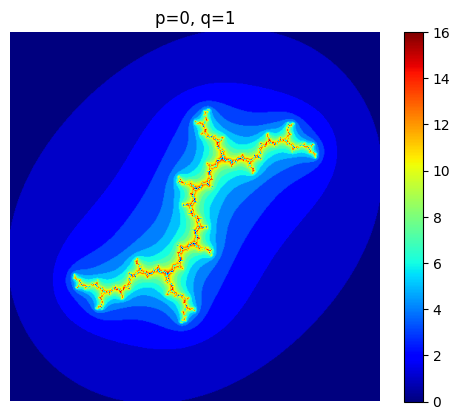

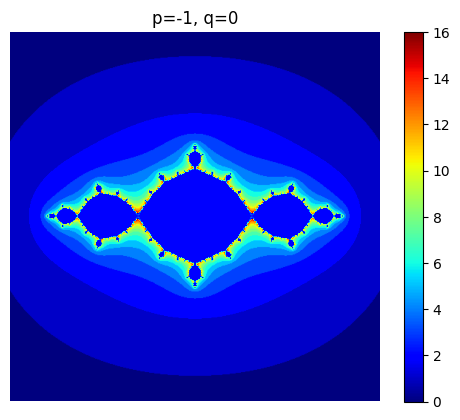

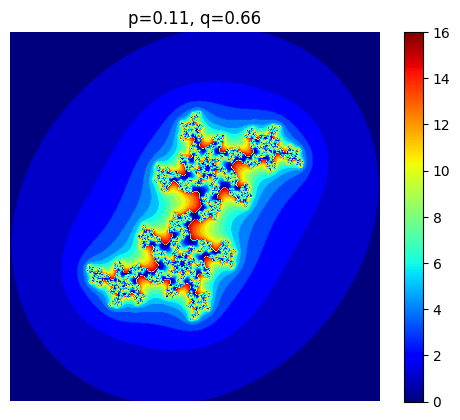

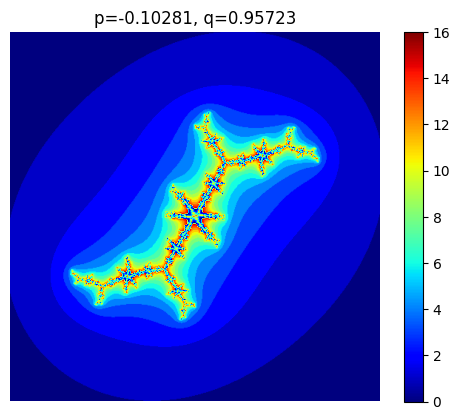

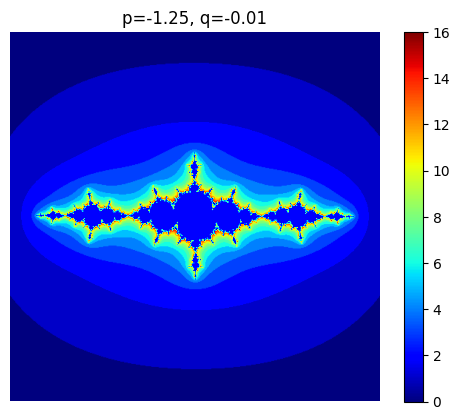

In [41]:
p_list = [0, -1, 0.11, -0.10281, -1.25]
q_list = [1, 0, 0.66, 0.95723, -0.01]

for i in range(5):
    julia_set(p_list[i], q_list[i])

## Q 9.3
### Question

IFS: Iterated Function System

$\omega_1(Z)=sZ+1, \omega_2(Z)=sZ-1, p_1=p_2=0.5$, where $s=0.5+0.5i$, draw the attractor of this IFS.

Take different values of $s$, what happens to the attractor?

### Solution

In [69]:
@np.vectorize
def omega1(s, Z):
    return s * Z + 1

@np.vectorize
def omega2(s, Z):
    return s * Z - 1

@np.vectorize
def omega(s, Z):
    return omega1(s, Z) if random.rand() < 0.5 else omega2(s, Z)

def draw_omega(s, n=10000):
    Z = np.zeros(shape=(n,), dtype=np.complex128)
    for i in range(n):
        Z[i] = omega(s, Z[i - 1])
    plt.figure()
    plt.scatter(Z.real, Z.imag, s=0.1)
    plt.gca().set_aspect("equal")
    plt.gca().set_title("s={}".format(s))
    plt.axis("off")

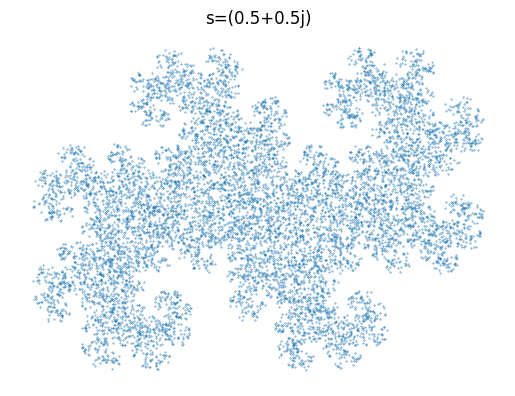

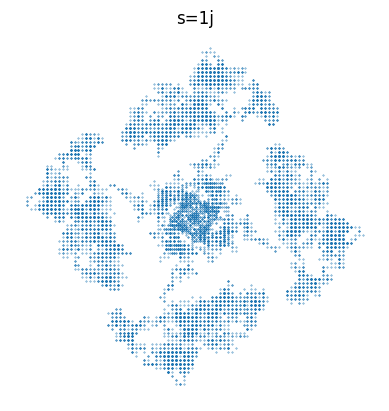

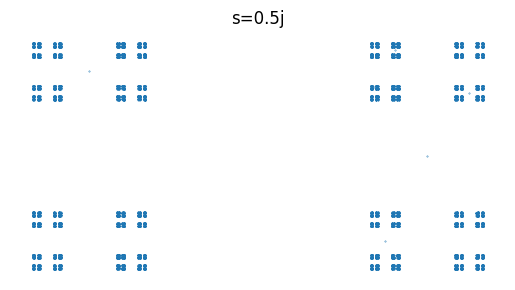

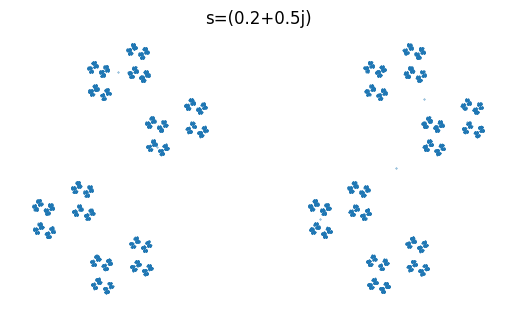

In [70]:
s_list = [0.5 + 0.5 * 1j, 1j, 0.5j, 0.2 + 0.5 * 1j]
for s in s_list:
    draw_omega(s)

## Q 9.4
### Question

Draw Feigenbaum diagram of $x_{n+1}=rx_n(1-x_n)$, where $x\in (0,1]$, $r\in [0,4]$. What do you see?

### Solution

In [71]:
@np.vectorize
def f(r, x):
    return r * x * (1 - x)

def draw_feigenbaum():
    # for each r, iterate x=(0,1] 100 times plot the last 50 points
    r_list = np.linspace(0, 4, 1000)
    x_list = np.linspace(0, 1, 100)
    X, R = np.meshgrid(x_list, r_list)
    Z = np.zeros(shape=(1000, 1000), dtype=np.float64)
    for i in range(100):
        Z = f(R, Z)
    plt.figure()
    plt.imshow(Z, extent=(0, 1, 0, 4), cmap="jet")
    plt.gca().set_aspect("auto")
    plt.gca().set_title("Feigenbaum diagram")
    plt.colorbar()

In [72]:
draw_feigenbaum()

ValueError: operands could not be broadcast together with shapes (1000,100) (1000,1000) 